# Ses Frekans Analiz ve Düzenleme Aracı (Textbox Versiyon)

Bu araç ile:
1. WAV dosyası yükleyip Fourier analizi yapabilirsiniz
2. Frekans-amplitüd grafiğini görüntüleyebilirsiniz
3. Textbox ile frekans seçip amplitüdünü değiştirebilirsiniz
4. Değişiklikleri kaydedip geri yükleyebilirsiniz
5. Sonucu WAV dosyası olarak dışa aktarabilirsiniz

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, ifft, fftfreq
import json
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
from collections import OrderedDict

## 1. WAV Dosyası Yükleme ve Fourier Analizi

In [2]:
def upload_wav():
    from google.colab import files
    uploaded = files.upload()
    for filename in uploaded.keys():
        if filename.lower().endswith('.wav'):
            return filename
    return None

In [3]:
def analyze_audio(filename):
    # Ses dosyasını yükle
    sample_rate, data = wavfile.read(filename)

    # Mono'ya çevir (stereo ise)
    if len(data.shape) > 1:
        data = data.mean(axis=1)

    # FFT hesapla
    n = len(data)
    yf = fft(data)
    xf = fftfreq(n, 1 / sample_rate)

    # Sadece pozitif frekansları al
    half_n = n // 2
    xf = xf[:half_n]
    yf = 2/n * np.abs(yf[:half_n])

    # Sonuçları JSON olarak kaydet
    fourier_data = {str(freq): float(amp) for freq, amp in zip(xf, yf)}
    scheme = {"frequency": "amplitude"}

    combined = OrderedDict()
    combined.update(scheme)      # önce "frequency": "amplitude"
    combined.update(fourier_data)

    with open('fourier-analysis.json', 'w') as f:
        json.dump(combined, f)

    return xf, yf, sample_rate, data

In [4]:
# Kullanıcıdan WAV dosyası yüklemesini iste
print("Lütfen analiz edilecek WAV dosyasını yükleyin:")
filename = upload_wav()

if filename:
    print(f"'{filename}' dosyası analiz ediliyor...")
    freqs, amps, sample_rate, original_data = analyze_audio(filename)
    print("Fourier analizi tamamlandı ve 'fourier-analysis.json' olarak kaydedildi.")
else:
    print("WAV dosyası yüklenmedi. Lütfen sonra tekrar deneyin.")

Lütfen analiz edilecek WAV dosyasını yükleyin:


Saving guitar.wav to guitar (1).wav
'guitar (1).wav' dosyası analiz ediliyor...


<ipython-input-3-164d1c397a7d>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


Fourier analizi tamamlandı ve 'fourier-analysis.json' olarak kaydedildi.


## 2. Frekans Grafiğini Görüntüleme

In [5]:
# Grafik oluşturma fonksiyonu
def plot_frequencies(freqs, amps, selected_freq=None):
    plt.figure(figsize=(15, 6))

    # Tüm frekansları çiz
    plt.plot(freqs, amps, color='blue', alpha=0.7, label='Frekans Spektrumu')

    # Seçilen frekansı vurgula (varsa)
    if selected_freq is not None:
        idx = np.abs(freqs - selected_freq).argmin()
        plt.scatter(freqs[idx], amps[idx], color='red', s=100, label=f'Seçilen: {selected_freq:.2f} Hz')

    plt.title('Frekans - Amplitüd Grafiği')
    plt.xlabel('Frekans (Hz)')
    plt.ylabel('Amplitüd')
    plt.xscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.show()

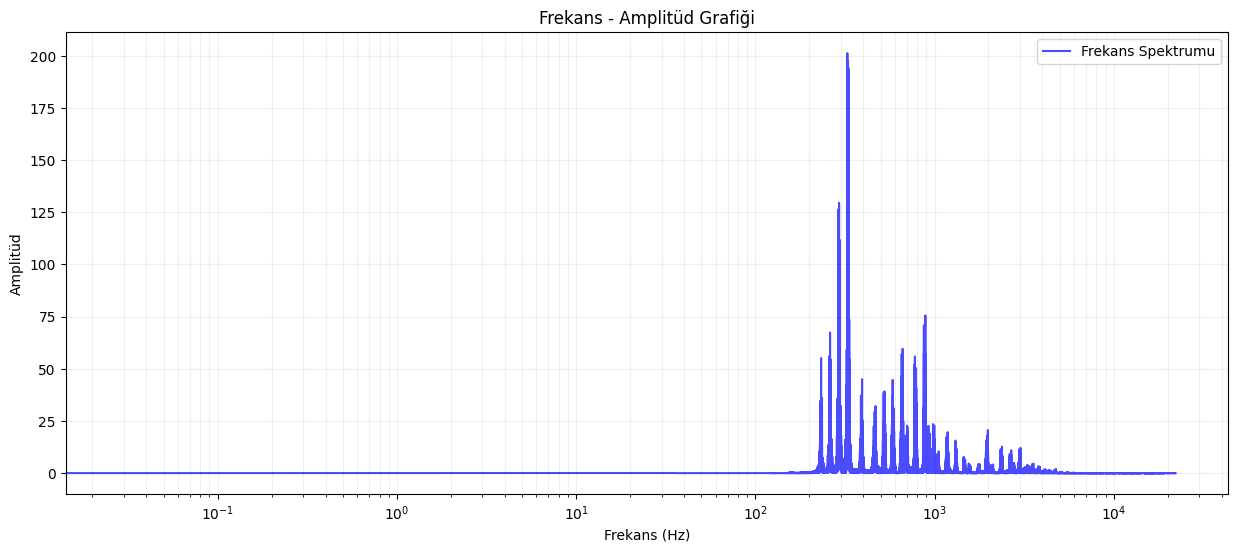

In [6]:
# Grafiği göster
if 'freqs' in locals() and 'amps' in locals():
    plot_frequencies(freqs, amps)

## 3. Textbox ile Frekans Düzenleme Arayüzü

In [7]:
# Değişiklikleri takip etmek için global değişkenler
modified_amps = amps.copy() if 'amps' in locals() else None
current_selected_freq = None
current_impact_range = 1000
parabolic_impact = False

In [8]:
def select_frequency(change):
    global current_selected_freq

    try:
        selected_freq = float(freq_text.value)
        if selected_freq < 0:
            print("Frekans değeri pozitif olmalıdır!")
            return

        current_selected_freq = selected_freq
        idx = np.abs(freqs - selected_freq).argmin()

        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps, current_selected_freq)
        display(ui_controls)

        print(f"Seçilen Frekans: {current_selected_freq:.2f} Hz, Mevcut Amplitüd: {modified_amps[idx]:.2f}")

    except ValueError:
        print("Lütfen geçerli bir frekans değeri girin!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")

In [9]:
def apply_changes(change):
    global modified_amps, current_selected_freq, current_impact_range, parabolic_impact

    if current_selected_freq is None:
        print("Lütfen önce bir frekans seçin!")
        return

    try:
        # Kullanıcı girdilerini al
        amplitude_change = float(amplitude_text.value)
        current_impact_range = float(impact_range_text.value)
        parabolic_impact = parabolic_checkbox.value

        # Seçilen frekansın indeksini bul
        target_idx = np.abs(freqs - current_selected_freq).argmin()

        # Amplitüd değişikliğini uygula
        if parabolic_impact and current_impact_range > 0:
            # Parabolik etki uygula
            start_freq = max(0, current_selected_freq - current_impact_range)
            end_freq = current_selected_freq + current_impact_range

            start_idx = np.abs(freqs - start_freq).argmin()
            end_idx = np.abs(freqs - end_freq).argmin()

            for i in range(start_idx, end_idx + 1):
                # Parabolik ağırlık hesapla (tepe noktası seçilen frekansta)
                distance = np.abs(freqs[i] - current_selected_freq)
                if distance <= current_impact_range:
                    # Normalize edilmiş mesafe (0-1 arası)
                    normalized_dist = distance / current_impact_range
                    # Parabolik ağırlık (1 - x^2)
                    weight = 1 - (normalized_dist ** 2)
                    modified_amps[i] += amplitude_change * weight
        else:
            # Sadece seçilen frekansı değiştir
            modified_amps[target_idx] += amplitude_change

        # Grafiği güncelle
        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps, current_selected_freq)
        display(ui_controls)

        print(f"Değişiklikler uygulandı: {current_selected_freq:.2f} Hz frekansına {amplitude_change:.2f} amplitüd değişikliği")
        if parabolic_impact:
            print(f"Parabolik etki: ±{current_impact_range:.2f} Hz aralığına uygulandı")

    except ValueError:
        print("Lütfen geçerli sayısal değerler girin!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")

In [10]:
def zero_amplitude_umwelt(change):
    global modified_amps, current_selected_freq, current_impact_range, parabolic_impact

    if current_selected_freq is None:
        print("Lütfen önce bir frekans seçin!")
        return

    try:
        current_impact_range = float(impact_range_text.value)
        parabolic_impact = parabolic_checkbox.value

        # Seçilen frekansın indeksini bul
        target_idx = np.abs(freqs - current_selected_freq).argmin()

        if parabolic_impact and current_impact_range > 0:
            # Parabolik etki uygulanacak aralığı belirle
            start_freq = max(0, current_selected_freq - current_impact_range)
            end_freq = current_selected_freq + current_impact_range

            start_idx = np.abs(freqs - start_freq).argmin()
            end_idx = np.abs(freqs - end_freq).argmin()

            for i in range(start_idx, end_idx + 1):
                distance = np.abs(freqs[i] - current_selected_freq)
                if distance <= current_impact_range:
                    modified_amps[i] = 0.0  # Sıfırlama
        else:
            modified_amps[target_idx] = 0.0  # Sadece seçilen frekansı sıfırla

        # Grafiği güncelle
        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps, current_selected_freq)
        display(ui_controls)

        print(f"{current_selected_freq:.2f} Hz frekansı sıfırlandı.")
        if parabolic_impact:
            print(f"Parabolik sıfırlama: ±{current_impact_range:.2f} Hz aralığına uygulandı")

    except ValueError:
        print("Lütfen geçerli sayısal değerler girin!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")

In [11]:
def zero_amplitude(change):
    global modified_amps, current_selected_freq, current_impact_range, parabolic_impact

    if current_selected_freq is None:
        print("Lütfen önce bir frekans seçin!")
        return

    try:
        current_impact_range = float(impact_range_text.value)
        parabolic_impact = parabolic_checkbox.value

        # Seçilen frekansın indeksini bul
        target_idx = np.abs(freqs - current_selected_freq).argmin()

        if parabolic_impact and current_impact_range > 0:
            # Parabolik etki uygulanacak aralığı belirle
            start_freq = max(0, current_selected_freq - current_impact_range)
            end_freq = current_selected_freq + current_impact_range

            start_idx = np.abs(freqs - start_freq).argmin()
            end_idx = np.abs(freqs - end_freq).argmin()

            for i in range(start_idx, end_idx + 1):
                distance = np.abs(freqs[i] - current_selected_freq)
                if distance <= current_impact_range:
                    normalized_dist = distance / current_impact_range  # 0–1 arası
                    weight = 1 - (normalized_dist ** 2)  # parabol: 1 tepe, 0 kenarlar
                    modified_amps[i] *= (1 - weight)  # %100 azalma → 0, %0 azalma → kalır
        else:
            modified_amps[target_idx] = 0.0  # Sadece seçilen frekansı sıfırla

        # Grafiği güncelle
        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps, current_selected_freq)
        display(ui_controls)

        print(f"{current_selected_freq:.2f} Hz frekansı parabolik olarak zayıflatıldı.")
        if parabolic_impact:
            print(f"Parabolik etki: ±{current_impact_range:.2f} Hz aralığında uygulandı")

    except ValueError:
        print("Lütfen geçerli sayısal değerler girin!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")


In [12]:
def save_changes(b):
    changes = {
        'modified_amps': modified_amps.tolist(),
        'selected_freq': current_selected_freq,
        'impact_range': current_impact_range,
        'parabolic_impact': parabolic_impact
    }

    with open('eq_settings.json', 'w') as f:
        json.dump(changes, f)

    print("Ayarlar 'eq_settings.json' olarak kaydedildi.")

In [13]:
def load_changes(b):
    global modified_amps, current_selected_freq, current_impact_range, parabolic_impact

    try:
        with open('eq_settings.json', 'r') as f:
            changes = json.load(f)

        modified_amps = np.array(changes['modified_amps'])
        current_selected_freq = changes['selected_freq']
        current_impact_range = changes['impact_range']
        parabolic_impact = changes['parabolic_impact']

        # UI elemanlarını güncelle
        freq_text.value = str(current_selected_freq) if current_selected_freq else ''
        amplitude_text.value = '0'
        impact_range_text.value = str(current_impact_range)
        parabolic_checkbox.value = parabolic_impact

        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps, current_selected_freq)
        display(ui_controls)

        print("Ayarlar başarıyla yüklendi!")

    except FileNotFoundError:
        print("Kaydedilmiş ayar dosyası bulunamadı!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")

In [14]:
def export_audio(b):
    global modified_amps, freqs, sample_rate, original_data

    try:
        # Orijinal verinin uzunluğu
        n = len(original_data)

        # FFT hesapla
        yf = fft(original_data)

        # Modified_amps boyutunu kontrol et ve gerekirse ayarla
        expected_length = n // 2
        if len(modified_amps) != expected_length:
            print(f"Uyarı: modified_amps boyutu ({len(modified_amps)}) beklenen ({expected_length}) ile uyuşmuyor. Ayarlanıyor...")
            if len(modified_amps) > expected_length:
                modified_amps = modified_amps[:expected_length]
            else:
                modified_amps = np.pad(modified_amps, (0, expected_length - len(modified_amps)), 'constant')

        # Scale faktörünü hesapla (sıfır bölme hatasını önle)
        original_magnitudes = 2/n * np.abs(yf[:expected_length])
        scale_factor = np.divide(modified_amps, original_magnitudes,
                               where=original_magnitudes!=0,
                               out=np.ones_like(original_magnitudes))

        # FFT sonucunu modifiye et
        yf[:expected_length] *= scale_factor
        yf[-expected_length:] *= scale_factor[::-1]  # Negatif frekanslar için

        # Ters FFT ile zaman domainine dön
        modified_data = np.real(ifft(yf))

        # Normalizasyon ve 16-bit dönüşüm
        peak = np.max(np.abs(modified_data))
        modified_data = np.int16(modified_data * (32767 / (peak + 1e-10)))  # Sıfıra bölmeyi önle

        # Dosyaya yaz
        output_filename = 'modified_' + filename
        wavfile.write(output_filename, sample_rate, modified_data)

        print(f"Başarıyla kaydedildi: {output_filename}")
        print("İndirmek için:")
        from google.colab import files
        files.download(f"{output_filename}")

    except Exception as e:
        print(f"Hata: {str(e)}")
        print(f"Detaylar: Orijinal veri: {len(original_data)}, FFT boyutu: {len(yf)}, Modified amps: {len(modified_amps)}")

In [19]:
def shift_frequencies(change):
    global modified_amps, freqs

    try:
        shift_amount = float(shift_text.value)

        # Yeni frekans dizisi oluştur
        shifted_freqs = freqs + shift_amount

        # Negatif frekansları önlemek için sıfırla
        shifted_freqs[shifted_freqs < 0] = 0

        # Amplitüdleri yeni frekanslara göre enterpole et
        from scipy.interpolate import interp1d
        interp_func = interp1d(shifted_freqs, modified_amps, bounds_error=False, fill_value=0)
        modified_amps = interp_func(freqs)

        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps)
        display(ui_controls)

        print(f"Spektrum {shift_amount:.2f} Hz kaydırıldı.")

    except ValueError:
        print("Lütfen geçerli bir sayı girin!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")

In [20]:
# UI Kontrollerini oluştur
freq_text = widgets.FloatText(value=0.0, description='Frekans (Hz):', continuous_update=False)
amplitude_text = widgets.FloatText(value='0', description='Amplitüd Değişimi:')
impact_range_text = widgets.FloatText(value='1000', description='Etki Aralığı (Hz):')
parabolic_checkbox = widgets.Checkbox(value=False, description='Parabolik etki uygula')


zero_button = widgets.Button(description="Sıfırla", button_style='danger')
zero_umwelt_button = widgets.Button(description="Sıfırla (Etki Aralığı boyunca hepsini)", button_style='danger')
select_button = widgets.Button(description="Frekansı Seç")
apply_button = widgets.Button(description="Değişiklikleri Uygula")
save_button = widgets.Button(description="Ayarları Kaydet")
load_button = widgets.Button(description="Ayarları Yükle")
export_button = widgets.Button(description="Sesi Dışa Aktar")

zero_button.on_click(zero_amplitude)
zero_umwelt_button.on_click(zero_amplitude_umwelt)
freq_text.observe(select_frequency, names='value')
apply_button.on_click(apply_changes)
save_button.on_click(save_changes)
load_button.on_click(load_changes)
export_button.on_click(export_audio)

# Shift UI elemanlarını oluştur
shift_text = widgets.FloatText(value='0', description='Kaydırma (Hz):')
shift_button = widgets.Button(description="Spektrumu Kaydır")
shift_button.on_click(shift_frequencies)

ui_controls = widgets.VBox([
    freq_text,
    widgets.HBox([select_button]),
    amplitude_text,
    impact_range_text,
    parabolic_checkbox,
    widgets.HBox([apply_button, save_button, load_button, zero_button, zero_umwelt_button]),
    export_button,

    widgets.HTML("<h3>Frekans Spektrumunu Kaydır</h3>"),
    widgets.HTML("<p>Mevcut spektrumu belirtilen miktarda kaydırır. Pozitif değer yüksek frekanslara, negatif değer düşük frekanslara kaydırır.</p>"),
    shift_text,
    shift_button
])

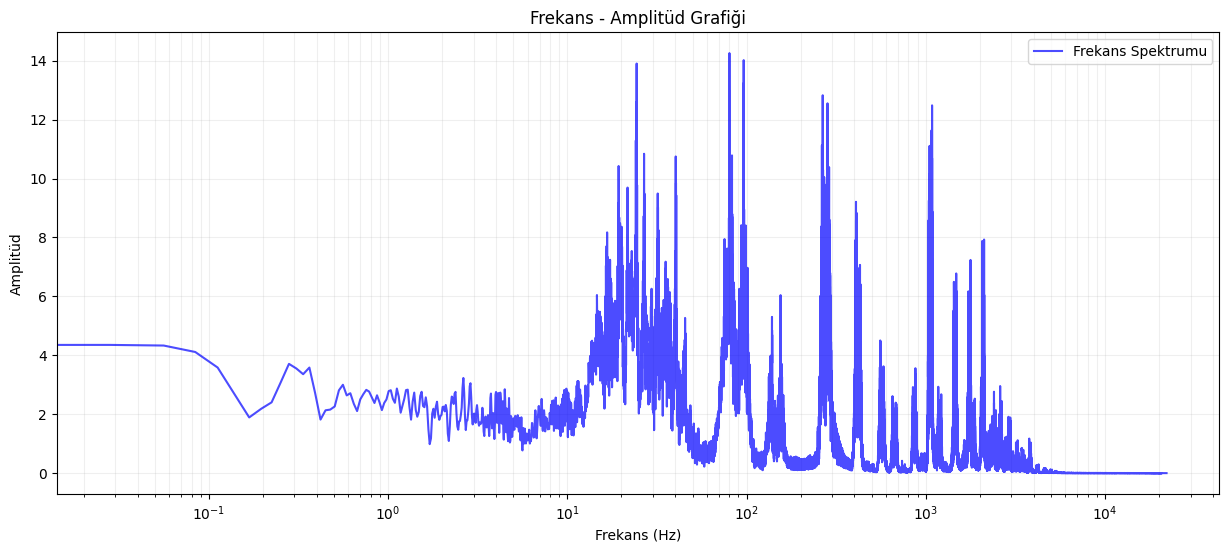

Spektrum -1000.00 Hz kaydırıldı.
Başarıyla kaydedildi: modified_guitar (1).wav
İndirmek için:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Arayüzü göster
if 'freqs' in locals() and 'amps' in locals():
    display(ui_controls)
    plot_frequencies(freqs, modified_amps)

## Kullanım Talimatları

1. Önce bir WAV dosyası yükleyin
2. 'Frekans (Hz)' textbox'ına düzenlemek istediğiniz frekansı girin ve 'Frekansı Seç' butonuna basın
3. Amplitüd değişikliğini ve isteğe bağlı parabolik etki ayarlarını girin
4. 'Değişiklikleri Uygula' butonuna basın
5. İşiniz bittiğinde 'Ayarları Kaydet' butonu ile çalışmanızı kaydedebilir
   veya 'Sesi Dışa Aktar' butonu ile modifiye edilmiş sesi WAV olarak indirebilirsiniz